In [1]:
import os
os.chdir('/Users/Olivier/anaconda3/envs/FEM')
%load_ext autoreload

In [2]:
%autoreload 2
from FEMOL import RectangleQuadMesh, FEM_Problem, TOPOPT_Problem
from FEMOL_utils import *
import timeit
np.set_printoptions(linewidth=150)

# Developping Notebook

## Testing the actual function

In [173]:
nelx = 100 # elements in the x direction
nely = 100 # elements in the y direction

# Creating the mesh
Lx = nelx
Ly = nely
mesh = RectangleQuadMesh(Lx, Ly, nelx, nely)
plate_problem = FEM_Problem(mesh, material=general_carbon())
layup = [0, 0, 0, 0]
plate_problem.orthotropic_plane_stress_tensor(layup)
plate_problem.orthotropic_bending_stress_tensor(layup)
plate_problem.out_of_plane_shear(1000)
plate_problem.complete_plate_Ke()
plate_problem.assemble_plate_K() # 1.83 s ± 56.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# Fixing some boundary
fixed_domain = create_domain([0], [[0, Ly]])
plate_problem.add_fixed_domain(fixed_domain)

fixed_domain = create_domain([Lx], [[0, Ly]])
plate_problem.add_fixed_domain(fixed_domain)

fixed_domain = create_domain([[0, Lx]], [0])
plate_problem.add_fixed_domain(fixed_domain)

fixed_domain = create_domain([[0, Lx]], [Ly])
plate_problem.add_fixed_domain(fixed_domain)

plate_problem.fix_boundary()

# Appliying some force
force = [0, 0, -1e-2, 0, 0, 0]
force_domain = create_domain([[9*Lx/20, 11*Lx/20]], [[9*Ly/20, 11*Ly/20]])
plate_problem.add_forces(force, force_domain)

# Solving
displacement = plate_problem.solve() # 1.1 s ± 8.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

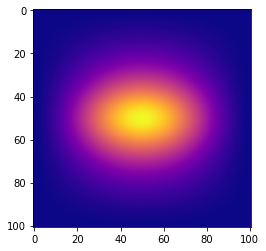

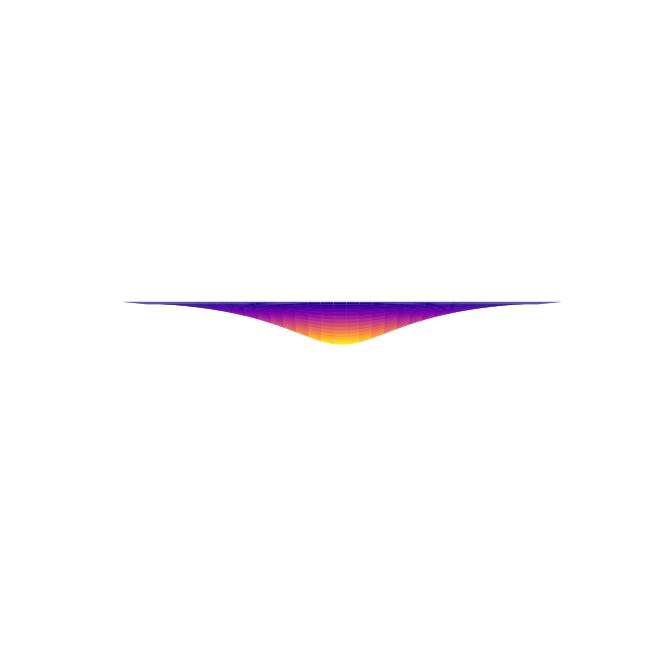

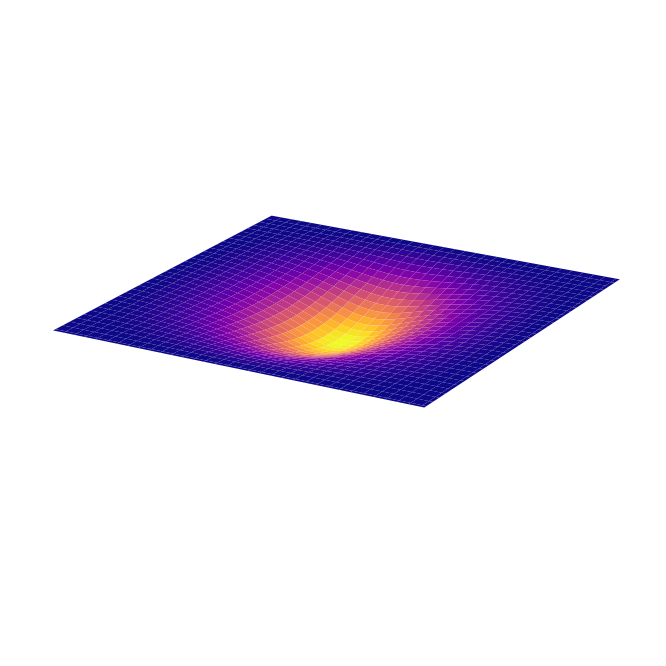

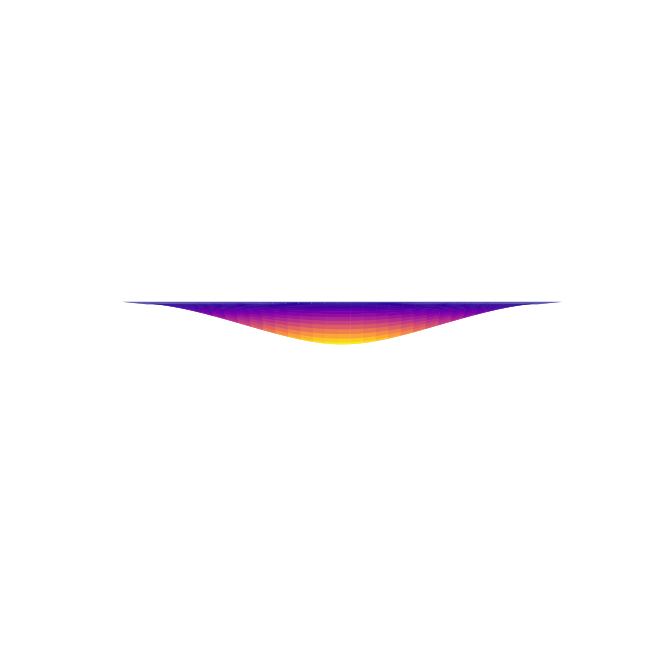

In [175]:
reshaped_displacement = []
for Ui in displacement:
    reshaped_displacement.append(np.flip(Ui.reshape(mesh.nodes_y, mesh.nodes_x), axis=0))

Ux, Uy, Uz, Tx, Ty, Tz = reshaped_displacement
plt.imshow(Uz, cmap='plasma_r')
plt.show()

x, y = mesh.CORG.transpose()
x = np.unique(x)
y = np.unique(y)
xg, yg = np.meshgrid(x, y)
scale=10e-2

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,12))
surf = ax.plot_surface(xg, yg, Uz*scale, cmap='plasma_r')
ax.set_box_aspect((np.ptp(xg), np.ptp(yg), np.ptp(Uz*scale)))
ax.view_init(azim=0, elev=0)
ax.set_axis_off()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,12))
surf = ax.plot_surface(xg, yg, Uz*scale, linewidth=0, cmap='plasma_r')
ax.set_box_aspect((np.ptp(xg), np.ptp(yg), np.ptp(Uz*scale)))
ax.view_init(azim=30, elev=20)
ax.set_axis_off()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,12))
surf = ax.plot_surface(xg, yg, Uz*scale, cmap='plasma_r')
ax.set_box_aspect((np.ptp(xg), np.ptp(yg), np.ptp(Uz*scale)))
ax.view_init(azim=90, elev=0)
ax.set_axis_off()

## Making the assembly faster

In [171]:
nelx = 100 # elements in the x direction
nely = 100 # elements in the y direction

# Creating the mesh
Lx = nelx
Ly = nely
mesh = RectangleQuadMesh(Lx, Ly, nelx, nely)
problem2 = FEM_Problem(mesh, material=general_carbon())
layup = [0, 0, 0, 0]
problem2.orthotropic_plane_stress_tensor(layup)
problem2.orthotropic_bending_stress_tensor(layup)
problem2.out_of_plane_shear(1000)
problem2.complete_plate_Ke()

In [167]:
def assemble_slow(problem):
    self=problem
    self.kind = 'complete plate KU = F'
    N_ddls = self.N_ddls
    K1 = np.zeros([N_ddls * self.mesh.Nnodes, N_ddls * self.mesh.Nnodes])
    for ele in self.mesh.CONEC:
        for node, ke_index_1 in zip(ele, np.arange(0, 4*self.N_ddls-1, self.N_ddls)):
            for node2, ke_index_2 in zip(ele, np.arange(0, 4*self.N_ddls-1, self.N_ddls)):
                for ddl_1 in np.arange(N_ddls):
                    for ddl_2 in np.arange(N_ddls):
                        K_index_1 = N_ddls * node + ddl_1
                        K_index_2 = N_ddls * node2 + ddl_2
                        K1[K_index_1][K_index_2] += self.ke_plate[ke_index_1 + ddl_1][ke_index_2 + ddl_2]
            

In [168]:
def assemble_fast(problem):
    self=problem
    self.kind = 'complete plate KU = F'
    N_ddls = self.N_ddls
    K = np.zeros([N_ddls * self.mesh.Nnodes, N_ddls * self.mesh.Nnodes])
    for ele in self.mesh.CONEC:
        nodes2, nodes1 = np.meshgrid(ele, ele)[0].reshape(-1), np.meshgrid(ele, ele)[1].reshape(-1)
        ke_nodes = np.arange(0, 4*self.N_ddls-1, self.N_ddls)
        ke_idxs2, ke_idxs1 = np.meshgrid(ke_nodes, ke_nodes)[0].reshape(-1), np.meshgrid(ke_nodes, ke_nodes)[1].reshape(-1)
        for node1, node2, ke_1, ke_2 in zip(nodes1, nodes2, ke_idxs1, ke_idxs2):
            K[node1*N_ddls : node1*N_ddls+N_ddls, node2*N_ddls : node2*N_ddls+N_ddls] += self.ke_plate[ke_1:ke_1+N_ddls, ke_2:ke_2+N_ddls]


In [172]:
%timeit assemble_fast(problem2)

3.49 s ± 349 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
